**K Means Clustering**

Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

**What we want to acheive ?**

segerment the Customers based on RFM(Recency Frequency Monetary) so that the company can target its customers efficiently.

**R (Recency): Number of days since last purchase**

**F (Frequency): Number of tracsactions**

**M (Monetary): Total amount of transactions (revenue contributed)**

Note: Here Recency is inversely proportional to Frequency. means when Recency is high then Frequency is low and When Frequencyis high the Recencyis low.

In [157]:
import numpy as np
import  pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import r2_score, mean_squared_error
import pickle
import warnings
warnings.filterwarnings('ignore')

#### Import Dataset

In [79]:
from google.colab import files
uploaded = files.upload()

Saving OnlineRetail.csv to OnlineRetail (2).csv


In [80]:
retail = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [81]:
retail.shape

(541909, 8)

In [82]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [83]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [84]:
retail.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,float64
CustomerID,float64
Country,object


**Data Cleaning**

In [85]:
# Calculating the Missing Values % contribution in DF

df_null = round(100*(retail.isnull().sum()) /len(retail),2)
df_null

,0
InvoiceNo,0.00
StockCode,0.00
Description,0.27
Quantity,0.00
InvoiceDate,0.00
UnitPrice,0.00
CustomerID,24.93
Country,0.00


In [86]:
# Dropping rows having missing values
retail = retail.dropna()
retail.shape

(406829, 8)

In [87]:
# changing the datatypes of customer Id
retail['CustomerID'] = retail['CustomerID'].astype(str)

In [88]:
# New Attribute: Monetary
retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [89]:
# New Attribute: Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceDate'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [93]:
# merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on= 'CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [120]:
# New Attribute : Recency

# Convert to datetime to proper datatype

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format='mixed', dayfirst=True)
retail['InvoiceDate']

,InvoiceDate
0,2010-12-01 08:26:00
1,2010-12-01 08:26:00
2,2010-12-01 08:26:00
3,2010-12-01 08:26:00
4,2010-12-01 08:26:00
...,...
541904,2011-12-09 12:50:00
541905,2011-12-09 12:50:00
541906,2011-12-09 12:50:00
541907,2011-12-09 12:50:00


In [121]:
# Compute the maximum date to know the last transaction date

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [124]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [125]:
# Compute recency of customer

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,NaT
1,12347.0,1 days 20:58:00
2,12348.0,248 days 02:03:00
3,12349.0,NaT
4,12350.0,309 days 20:49:00


In [126]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,NaN
1,12347.0,1.0
2,12348.0,248.0
3,12349.0,NaN
4,12350.0,309.0


In [127]:
# Merge the dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,NaN
1,12347.0,4310.00,182,1.0
2,12348.0,1797.24,31,248.0
3,12349.0,1757.55,73,NaN
4,12350.0,334.40,17,309.0


In [131]:
# merge the dataframe to get the final RFM datafram

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm = rfm[['CustomerID', 'Amount', 'Frequency', 'Recency']]
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,NaN
1,12347.0,4310.00,182,1.0
2,12348.0,1797.24,31,248.0
3,12349.0,1757.55,73,NaN
4,12350.0,334.40,17,309.0


Text(0.5, 0, 'Attributes')

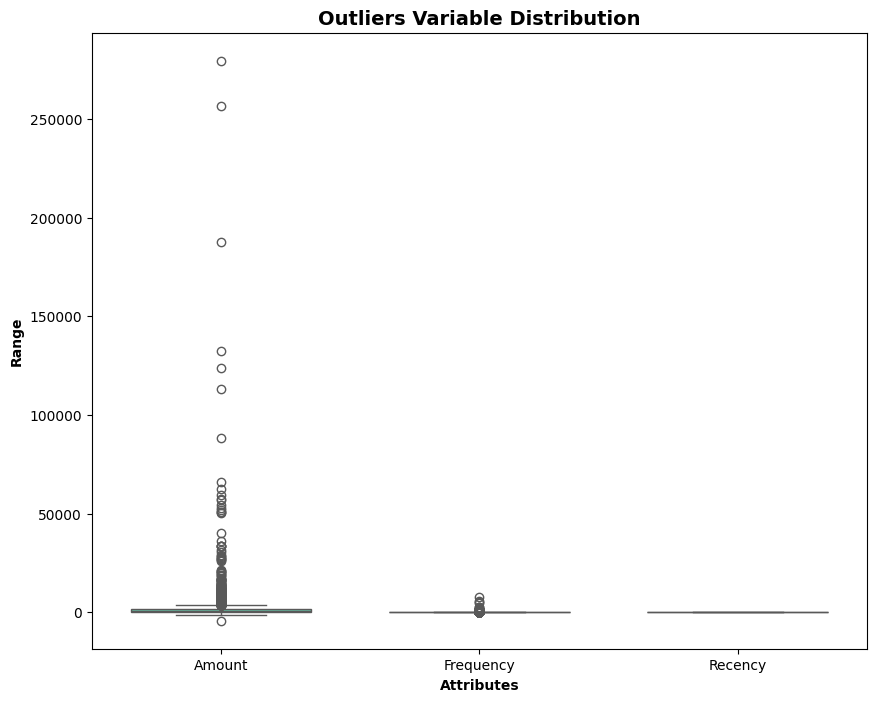

In [134]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8] #rcParams(runtime configuration parameters) means-> Matplotlib ke default plotting settings ko globally change karne ke liye use hota hai — jaise figure size, colors, fonts, grid, etc., taaki har plot ek consistent style me aaye.
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [142]:
# Removing (statistical) outliers for Amount.IQR-> it's used to detect Outlier which is present in dataset.
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1   #IQR-> is Interquartile Range, a key concept in statistics that measures the spread or variability of the middle 50% of a dataset, calculated as the difference between the third quartile (Q3, 75th percentile) and the first quartile (Q1, 25th percentile): IQR = Q3 - Q1. It's a robust measure, less affected by outliers than the standard deviation
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

rfm.head()

,CustomerID,Amount,Frequency,Recency
1,12347.0,4310.00,182,1.0
2,12348.0,1797.24,31,248.0
4,12350.0,334.40,17,309.0
5,12352.0,1545.41,95,35.0
8,12355.0,459.40,13,213.0


**Scaling the features**

Scaling means bringing all numerical features into a similar range so that the machine learning model doesn't give more importance to large-valued features and can train faster and more accurately.

In [143]:
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()    # scaler- > used to avoid biasness.

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(3037, 3)

In [148]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']

**Model Building**

In [150]:
# K-Means with some artributary k

kmeans = KMeans(n_clusters =4, max_iter = 50) #n_clusters-> means the number of clusters (groups). heremake 4 groups in the data, max_iter->maximum number of iterations:here maximum 50 times to adjust centroids
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [151]:
kmeans.labels_

array([2, 1, 1, ..., 0, 3, 0], dtype=int32)

In [152]:
set(kmeans.labels_)

{np.int32(0), np.int32(1), np.int32(2), np.int32(3)}

**Elbow Curve to get the right number of clusters**

Elbow Curve is a graph that helps you decide the best number of clusters (K) for K-Means.
Because we don’t know how many clusters our data should have.
Elbow curve shows a point where adding more clusters doesn’t improve the result much.

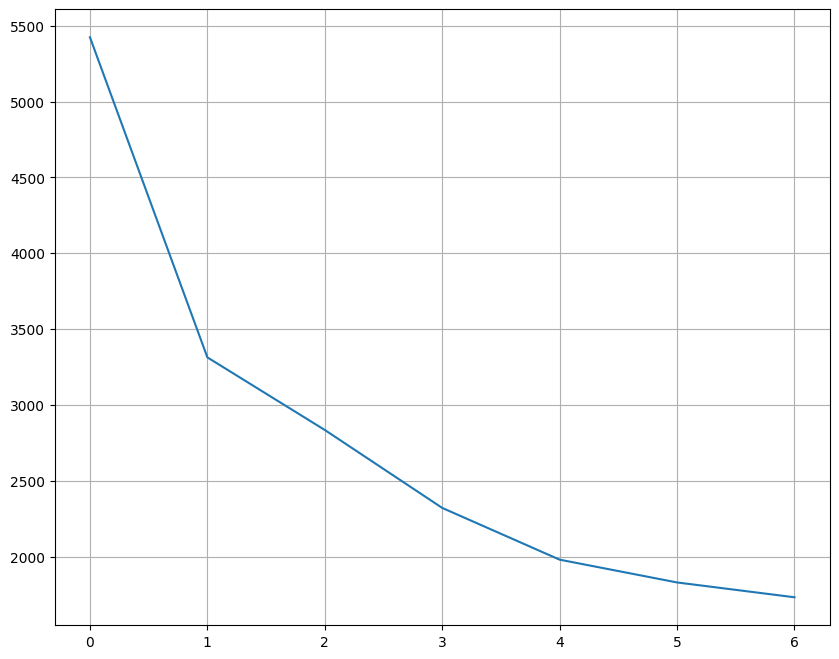

In [154]:
ssd =[]
range_n_clusters = [2,3,4,5,6,7,8]
for num_clusters in range_n_clusters:
  kmeans= KMeans(n_clusters= num_clusters, max_iter=50)
  kmeans.fit(rfm_df_scaled)
  ssd.append(kmeans.inertia_) # Every cluster ke centroid se uske data points tak ke total squared distances ko ssd varriable me value store krti h.
  #ssd(Sum of Squared Distances)-> is a varriable to store distance.
  # inertia_-> gives the attributes.inertia->inertia basically just a difference. ek cluster me two points ka difference.

# plot the SSDs for each n_clusters
plt.plot(ssd)
plt.grid(True)

In [155]:
# Final model with k = 3
kmeans = KMeans(n_clusters=3, max_iter=300)
kmeans.fit(rfm_df_scaled)

KMeans(n_clusters=3)

In [156]:
kmeans.labels_

array([2, 1, 1, ..., 0, 2, 0], dtype=int32)

**Save the model**

In [159]:
# Define filename for pickle file
filename = 'kmeans_model.pkl'

#open file in wrote model
with open('kmeans_saved_model', 'wb') as file:
  # save the kmeans model to file
  pickle.dump(kmeans, file)

# close the file
file.close()

pickle.dump(kmeans, open('kmeans_model.pkl', 'wb'))

In [160]:
kmeans.predict(rfm_df_scaled)

array([2, 1, 1, ..., 0, 2, 0], dtype=int32)

In [162]:
# assign the label
rfm['Customer_ID'] = kmeans.predict(rfm_df_scaled)
rfm.head()

,CustomerID,Amount,Frequency,Recency,Customer_ID
1,2,4310.00,182,1.0,2
2,1,1797.24,31,248.0,1
4,1,334.40,17,309.0,1
5,0,1545.41,95,35.0,0
8,1,459.40,13,213.0,1


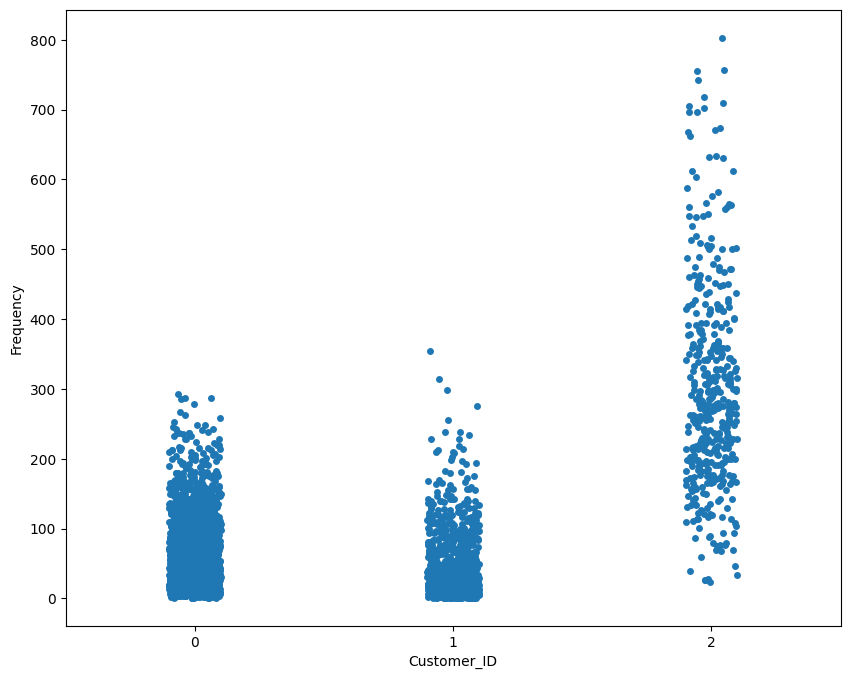

In [168]:
# Box plot to visualize Cluster Id vs Amount

sns.stripplot(x ='Customer_ID', y='Frequency', data = rfm)
plt.savefig('Cluster_IDFrequency.png')

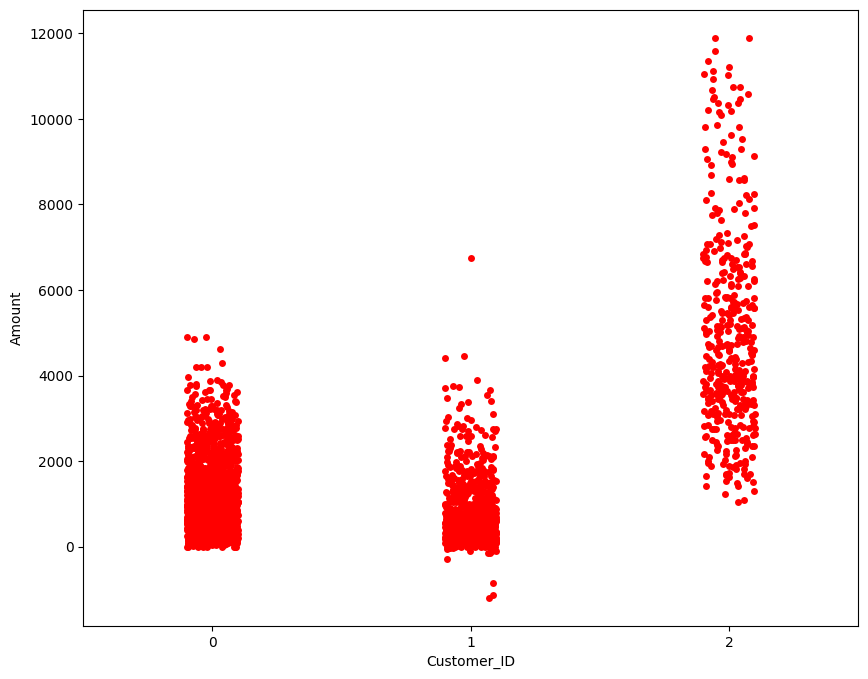

In [171]:
# Box plot tp visuliaze Cluster Id Vs Amount

sns.stripplot(x ='Customer_ID', y='Amount', data = rfm, color ='r')
plt.savefig('Cluster_IDAmount.png')